In [1]:
import numpy as np 
import pandas as pd 
import scanpy as sc 
import lightgbm as lgb 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score 
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.model_selection import train_test_split
from tqdm import tqdm 
import anndata as ad 
import sys  
sys.path.append('/home/rsun@ZHANGroup.local/sly_data/gbdt_lr')
from utils import load_data, GBDT_LR


# Description: 

In this notebook, we identify the marker gene set for each cluster in hippocampus excitatory neuron. 

We use the gradient boosting classifier to generate the gene combination for each cluster, then using logistic regresssion to identify the marker gene set.

Finally, we add additional modification to make the gene set more interpretable.

/tmp/ipykernel_1400151/2533628664.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['cluster 7', 'cluster 5', 'cluster 7', 'cluster 7', 'cluster 10', ..., 'cluster 1', 'cluster 8', 'cluster 1', 'cluster 1', 'cluster 1']
Length: 21861
Categories (11, object): ['cluster 1', 'cluster 7', 'cluster 5', 'cluster 8', ..., 'cluster 10', 'cluster 11', 'cluster 3', 'cluster 9']' has dtype incompatible with category, please explicitly cast to a compatible dtype first.
  scdata.obs.loc[:,'cluster'] = scdata.obs.leiden.map(cluster_dic)


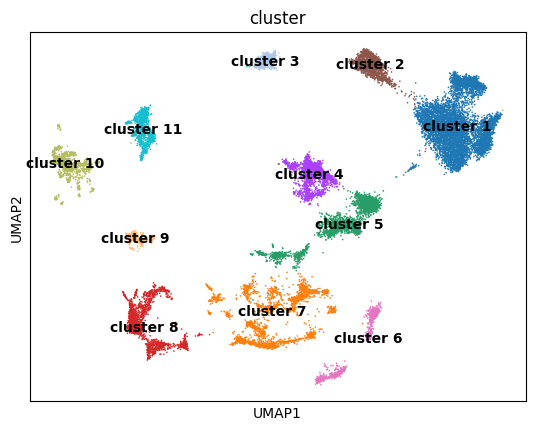

In [2]:
import json
with open('/home/rsun@ZHANGroup.local/sly_data/sly_06_require/leiden_dic.json', 'r') as f:
    cluster_dic = json.load(f)
scdata = sc.read_h5ad('/home/rsun@ZHANGroup.local/sly_data/celltype_check/modify_multi.h5ad')
scdata.obs.loc[:,'cluster'] = scdata.obs.leiden.map(cluster_dic)
sc.pl.umap(scdata, color = ['cluster'], legend_loc = 'on data')

## Using GBDT_LR method to generate gene set 

In [3]:
gbdt_lr = GBDT_LR(scdata, label_key = 'cluster') 
gbdt_lr.split_data()

C = gbdt_lr.label_encoder.classes_.shape[0]
print(f'cluster number {C}')

# 设置LightGBM参数
gbm_params = {
    'objective': 'multiclass',  # 多分类任务
    'num_class': C,  # 类别数量
    'metric': 'multi_logloss',  # 多分类的损失函数
    'boosting_type': 'gbdt',  # 使用GBDT算法
    'num_leaves': 5,  # 叶子节点数
    'learning_rate': 0.05,  # 学习率
    'feature_fraction': 0.9,  # 特征采样比例
    'bagging_fraction': 0.8,  # 数据采样比例
    'bagging_freq': 5,  # 每5次迭代进行一次bagging
    'verbose': 0  # 不输出详细信息
    }

gbdt_lr.gbm_fit(gbm_params)

cluster number 11
Training until validation scores don't improve for 10 rounds


Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.252351
best iteration: 100
ROC AUC Score on lg Data: 0.9946860325057721


In [4]:
gbdt_lr.gbm_transform()
gbdt_lr.lg_fit()

Start predicting...
Writing transformed training data


100%|██████████| 10930/10930 [00:00<00:00, 11308.13it/s]


Writing transformed testing data


100%|██████████| 10931/10931 [00:00<00:00, 11488.80it/s]
/home/rsun@ZHANGroup.local/sly_data/gbdt_lr/utils.py:177: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  testing_label = self.sc_new.obs.loc[:,self.label_key][testing_id]
/home/rsun@ZHANGroup.local/anaconda3/envs/snapatac/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/rsun@ZHANGroup.local/sly_dat

ROC AUC Score on lg split Data: 1.0
ROC AUC Score on gbm split Data: 0.9984331748906939


## Parse the decision tree node into intepretable feature

In [5]:
def parse_lightgbm_tree(tree, feature_names=None):
    """
    解析 LightGBM 树结构，生成叶节点路径条件表达式
    :param tree: 通过 model.dump_model()['tree_info'][0]['tree_structure'] 获取的树结构
    :param feature_names: 特征名称列表，若为 None 则使用 column_{index} 格式
    :return: 字典，键为叶节点索引，值为条件表达式字符串
    """
    def traverse(node, path, results):
        if 'leaf_index' in node:
            # 处理叶节点
            conditions = []
            for feat, thres, op in path:
                conditions.append(f"{feat} {op} {thres:.3f}")
            results[node['leaf_index']] = " and ".join(conditions)
        else:
            # 处理非叶节点
            feat_idx = node['split_feature']
            thres = node['threshold']
            feat_name = f"column_{feat_idx}" if feature_names is None else feature_names[feat_idx]
            
            # 左子树（<= 阈值）
            left_path = path + [(feat_name, thres, "<=")]
            traverse(node.get('left_child', {}), left_path, results)
            
            # 右子树（> 阈值）
            right_path = path + [(feat_name, thres, ">")]
            traverse(node.get('right_child', {}), right_path, results)
    
    results = {}
    traverse(tree, [], results)
    return results

In [6]:
from tqdm import tqdm 
N = gbdt_lr.gbm_model.num_trees()
num_leaves = gbdt_lr.gbm_params['num_leaves']

feature_names = scdata.var.index.values  # 根据实际特征数量调整
res_dic = {}
for i in tqdm(range(N)):
    tree_structure = gbdt_lr.gbm_model.dump_model()['tree_info'][i]['tree_structure']
    leaf_conditions = parse_lightgbm_tree(tree_structure, feature_names)

    for key in leaf_conditions:
        res_dic[num_leaves*i + key] = leaf_conditions[key] 

new_feature_name = [f'{res_dic[i]}' for i in range(N*num_leaves)]
new_feature_name = np.array(new_feature_name )

100%|██████████| 1100/1100 [02:48<00:00,  6.52it/s]


In [7]:
feature_dict = {gene: i for i, gene in enumerate(new_feature_name)}

unique_feature = np.unique(new_feature_name) 
unique_id = []

for ele in unique_feature:
    unique_id.append(feature_dict[ele])
unique_id = np.array(unique_id)

In [8]:
sc_new = gbdt_lr.sc_new 
sc_new.var.loc[:,'var_info'] = new_feature_name
sc_new = sc_new[:,unique_id]

# sc.tl.rank_genes_groups(sc_new, groupby = 'cluster', method = 'wilcoxon')
# sc.pl.rank_genes_groups_dotplot(sc_new, groupby = 'cluster', n_genes = 4,min_logfoldchange=2,)

In [24]:
df = sc.get.rank_genes_groups_df(sc_new, group = 'cluster 1')

for ele in df['names'][10:30]:
    print(ele, sc_new.var.loc[ele,'var_info'])

430 Rfx3 > 5.264 and Csmd1 <= 0.000
957 Elavl2 <= 0.000 and Ldb2 <= 0.000
1089 Elavl2 <= 0.000 and Ldb2 <= 1.984
1518 Man2a1 <= 0.000 and Nrxn1 <= 5.168
1255 Rfx3 > 4.941 and Csmd1 <= 3.178
462 Man2a1 <= 0.000 and Dock9 <= 2.354
133 Rfx3 > 5.276 and Mast4 <= 0.000
1815 Elavl2 <= 2.012 and Tenm2 <= 3.987
496 Rfx3 > 5.288 and Dock9 <= 2.354
1320 Satb2 <= 0.000 and Mgat4c <= 0.000
2178 Mgat4c <= 0.000 and Satb2 <= 2.720
760 Rfx3 > 5.048 and Cdh20 <= 0.000
661 Rfx3 > 5.288 and Cdh20 <= 0.000
2112 Sh3rf1 <= 0.000 and Tenm2 <= 4.854
2706 Sh3rf1 <= 0.000 and Tenm2 <= 5.406
859 Ccdc85a > 4.873 and Cdh20 <= 0.000
2323 Synpr > 4.103 and Stard13 <= 2.234
364 Ccdc85a > 5.002 and Cdh20 <= 0.000
2389 Synpr > 4.148 and Stard13 <= 2.234
1419 Satb2 <= 0.000 and Nrxn1 <= 5.168


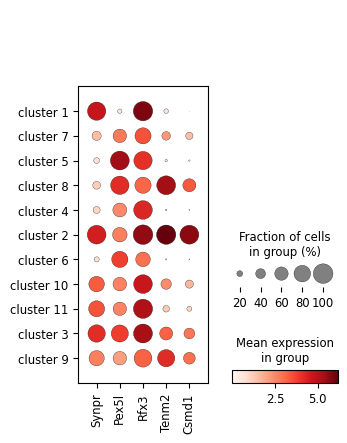

In [26]:
sc.pl.dotplot(scdata, var_names = ['Synpr','Pex5l','Rfx3','Tenm2', 'Csmd1'], groupby = 'cluster')

## cluster 1 gene set

Pex5l == 0 and (Synpr > 0 or Otof > 0) 

In [18]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
x = scdata.obsm['X_umap'][:,0]
y = scdata.obsm['X_umap'][:,1]
print(x.min(), x.max(), y.min(), y.max())

x_min, x_max = -3, 18
y_min, y_max = -2, 13

def plot_umap(x,y,color_array, title, border, positive, save_fig = None):
    if not positive:
        # 创建从灰色到蓝色的自定义 colormap
        colors = ['lightgray', 'gray', 'darkblue']
        cmap = LinearSegmentedColormap.from_list('gray_to_blue', colors, N=256)
    else:
        colors = ['lightgray', 'gray', 'darkred']
        cmap = LinearSegmentedColormap.from_list('gray_to_red', colors, N=256)
    x_min, x_max, y_min, y_max = border
    # 绘制散点图
    plt.figure(figsize=(6, 4))
    scatter = plt.scatter(x, y, c=color_array, cmap=cmap, s=1, alpha=1)

    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.colorbar(scatter, label='Gene Expression')

    plt.xlabel('UMAP 1')
    plt.ylabel('UMAP 2')
    if title is not None:
        plt.title(title)
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    
    if save_fig is not None:
        plt.savefig(save_fig, bbox_inches='tight')
    else:
        plt.show()


-2.7424016 17.407724 -1.3584764 12.464519


In [ ]:
idx_1 = scdata[:,'Pex5l'].X.toarray() == 0 
idx_2 = scdata[:,'Synpr'].X.toarray() > 4
idx_3 = scdata[:,'Otof'].X.toarray() > 0 
idx_4 = scdata[:,'Csmd1'].X.toarray() == 0
#idx_4 = scdata[:,'Rfx3'].X.toarray() > 5


idx = idx_1 & (idx_2 | idx_3) & idx_4

border = (-3,18,-2,13)

x = scdata.obsm['X_umap'][:,0]
y = scdata.obsm['X_umap'][:,1]

#plot_umap(x,y,idx.astype(int), None, border, False, save_fig = 'cluster_1.pdf')
scdata.obs.loc[:,'c1_idx'] = idx.astype(str)
scdata.obs.c1_idx = scdata.obs.c1_idx.astype('category')

sc.tl.embedding_density(scdata, groupby = 'c1_idx')
ax = sc.pl.embedding_density(
    scdata, basis='umap', key='umap_density_c1_idx', bg_dotsize=3, fg_dotsize= 3, color_map = 'coolwarm', group = 'True',show = False)
plt.savefig('cluster_1.pdf',bbox_inches = 'tight')


## cluster 2 gene set

Sox 5 == 0 and Csmd1 > 0 and Synpr >0

In [ ]:
idx_1 = scdata[:,'Csmd1'].X.toarray() > 0 
idx_2 = scdata[:,'Sox5'].X.toarray() == 0
idx_3 = scdata[:,'Synpr'].X.toarray() > 0
idx  = idx_1 & idx_2 & idx_3


x = scdata.obsm['X_umap'][:,0]
y = scdata.obsm['X_umap'][:,1]

#plot_umap(x,y,idx.astype(int), None, border, False, save_fig = 'cluster_2.pdf')
scdata.obs.loc[:,'c1_idx'] = idx.astype(str)
scdata.obs.c1_idx = scdata.obs.c1_idx.astype('category')

sc.tl.embedding_density(scdata, groupby = 'c1_idx')
ax = sc.pl.embedding_density(
    scdata, basis='umap', key='umap_density_c1_idx', bg_dotsize=3, fg_dotsize= 3, color_map = 'coolwarm', group = 'True',show = False)
plt.savefig('cluster_2.pdf',bbox_inches = 'tight')


## cluster 3 gene set

Mag > 0

In [ ]:

idx  = scdata[:,'Mag'].X.toarray() > 0

x = scdata.obsm['X_umap'][:,0]
y = scdata.obsm['X_umap'][:,1]

#plot_umap(x,y,idx.astype(int), None, border, False, save_fig = 'cluster_3.pdf')

scdata.obs.loc[:,'c1_idx'] = idx.astype(str)
scdata.obs.c1_idx = scdata.obs.c1_idx.astype('category')

sc.tl.embedding_density(scdata, groupby = 'c1_idx')
ax = sc.pl.embedding_density(
    scdata, basis='umap', key='umap_density_c1_idx', bg_dotsize=3, fg_dotsize= 3, color_map = 'coolwarm', group = 'True',show = False)
plt.savefig('cluster_3.pdf',bbox_inches = 'tight')

## cluster 4 gene set
Trhde > 0  and Epha3 == 0 and Satb2 == 0

In [ ]:

idx_1  = scdata[:,'Trhde'].X.toarray() > 0
idx_2 = scdata[:,'Epha3'].X.toarray() == 0 
idx_3 = scdata[:,'Satb2'].X.toarray() == 0
idx = idx_1 & idx_2 & idx_3

x = scdata.obsm['X_umap'][:,0]
y = scdata.obsm['X_umap'][:,1]

#plot_umap(x,y,idx.astype(int), None, border, False, save_fig = 'cluster_4.pdf')
scdata.obs.loc[:,'c1_idx'] = idx.astype(str)
scdata.obs.c1_idx = scdata.obs.c1_idx.astype('category')

sc.tl.embedding_density(scdata, groupby = 'c1_idx')
ax = sc.pl.embedding_density(
    scdata, basis='umap', key='umap_density_c1_idx', bg_dotsize=3, fg_dotsize= 3, color_map = 'coolwarm', group = 'True',show = False)
plt.savefig('cluster_4.pdf',bbox_inches = 'tight')

## cluster 5 gene set

idx_1 = scdata[:,'Pex5l'].X.toarray() > 5

idx_2 = scdata[:,'Erc2'].X.toarray() == 0

In [ ]:
idx_1 = scdata[:,'Pex5l'].X.toarray() > 5
idx_2 = scdata[:,'Erc2'].X.toarray() == 0

idx = idx_1 & idx_2
x = scdata.obsm['X_umap'][:,0]
y = scdata.obsm['X_umap'][:,1]

#plot_umap(x,y,idx.astype(int), None, border, False, save_fig = 'cluster_5.pdf')

scdata.obs.loc[:,'c1_idx'] = idx.astype(str)
scdata.obs.c1_idx = scdata.obs.c1_idx.astype('category')

sc.tl.embedding_density(scdata, groupby = 'c1_idx')
ax = sc.pl.embedding_density(
    scdata, basis='umap', key='umap_density_c1_idx', bg_dotsize=3, fg_dotsize= 3, color_map = 'coolwarm', group = 'True',show = False)
plt.savefig('cluster_5.pdf',bbox_inches = 'tight')

###

## cluster 6 gene set

In [ ]:
idx_1 = scdata[:,'Kctd16'].X.toarray() == 0
idx_2 = scdata[:,'Grin2b'].X.toarray() == 0

idx = idx_1 & idx_2
x = scdata.obsm['X_umap'][:,0]
y = scdata.obsm['X_umap'][:,1]

#plot_umap(x,y,idx.astype(int), None, border, False, save_fig = 'cluster_6.pdf')

scdata.obs.loc[:,'c1_idx'] = idx.astype(str)
scdata.obs.c1_idx = scdata.obs.c1_idx.astype('category')

sc.tl.embedding_density(scdata, groupby = 'c1_idx')
ax = sc.pl.embedding_density(
    scdata, basis='umap', key='umap_density_c1_idx', bg_dotsize=3, fg_dotsize= 3, color_map = 'coolwarm', group = 'True',show = False)
plt.savefig('cluster_6.pdf',bbox_inches = 'tight')

## cluster 7 gene set

In [ ]:
idx_1 = scdata[:,'Satb2'].X.toarray() > 0
idx_2 = scdata[:,'Bcl11b'].X.toarray() == 0


idx = idx_1 & idx_2
x = scdata.obsm['X_umap'][:,0]
y = scdata.obsm['X_umap'][:,1]

#plot_umap(x,y,idx.astype(int), None, border, False, save_fig = 'cluster_7.pdf')
scdata.obs.loc[:,'c1_idx'] = idx.astype(str)
scdata.obs.c1_idx = scdata.obs.c1_idx.astype('category')

sc.tl.embedding_density(scdata, groupby = 'c1_idx')
ax = sc.pl.embedding_density(
    scdata, basis='umap', key='umap_density_c1_idx', bg_dotsize=3, fg_dotsize= 3, color_map = 'coolwarm', group = 'True',show = False)
plt.savefig('cluster_7.pdf',bbox_inches = 'tight')

## cluster 8 geneset

In [ ]:
idx_1 = scdata[:,'Nrg3'].X.toarray() > 6
idx_2 = scdata[:,'Kcnh7'].X.toarray() > 2
idx_3 = scdata[:,'Nav3'].X.toarray() > 4


idx = idx_1  & idx_2 & idx_3
x = scdata.obsm['X_umap'][:,0]
y = scdata.obsm['X_umap'][:,1]

#plot_umap(x,y,idx.astype(int), None, border, False, save_fig = 'cluster_8.pdf')
scdata.obs.loc[:,'c1_idx'] = idx.astype(str)
scdata.obs.c1_idx = scdata.obs.c1_idx.astype('category')

sc.tl.embedding_density(scdata, groupby = 'c1_idx')
ax = sc.pl.embedding_density(
    scdata, basis='umap', key='umap_density_c1_idx', bg_dotsize=3, fg_dotsize= 3, color_map = 'coolwarm', group = 'True',show = False)
plt.savefig('cluster_8.pdf',bbox_inches = 'tight')

## cluster 9 geneset

In [ ]:
idx_1 = scdata[:,'Nrg3'].X.toarray() > 6
idx_2 = scdata[:,'Nectin3'].X.toarray() > 2

idx = idx_1  & idx_2 
x = scdata.obsm['X_umap'][:,0]
y = scdata.obsm['X_umap'][:,1]

#plot_umap(x,y,idx.astype(int), None, border, False, save_fig = 'cluster_9.pdf')
scdata.obs.loc[:,'c1_idx'] = idx.astype(str)
scdata.obs.c1_idx = scdata.obs.c1_idx.astype('category')

sc.tl.embedding_density(scdata, groupby = 'c1_idx')
ax = sc.pl.embedding_density(
    scdata, basis='umap', key='umap_density_c1_idx', bg_dotsize=3, fg_dotsize= 3, color_map = 'coolwarm', group = 'True',show = False)
plt.savefig('cluster_9.pdf',bbox_inches = 'tight')

## cluster 10 geneset

In [ ]:
idx_1 = scdata[:,'Dock8'].X.toarray() > 0
#idx_2 = scdata[:,'Nectin3'].X.toarray() > 2.3

idx = idx_1  #& idx_2 
x = scdata.obsm['X_umap'][:,0]
y = scdata.obsm['X_umap'][:,1]

#plot_umap(x,y,idx.astype(int), None, border, False, save_fig = 'cluster_10.pdf')
scdata.obs.loc[:,'c1_idx'] = idx.astype(str)
scdata.obs.c1_idx = scdata.obs.c1_idx.astype('category')

sc.tl.embedding_density(scdata, groupby = 'c1_idx')
ax = sc.pl.embedding_density(
    scdata, basis='umap', key='umap_density_c1_idx', bg_dotsize=3, fg_dotsize= 3, color_map = 'coolwarm', group = 'True',show = False)
plt.savefig('cluster_10.pdf',bbox_inches = 'tight')

## cluster 11 gene set

In [ ]:
idx_1 = scdata[:,'Slc1a3'].X.toarray() > 0
#idx_2 = scdata[:,'Nectin3'].X.toarray() > 2.3

idx = idx_1  #& idx_2 
x = scdata.obsm['X_umap'][:,0]
y = scdata.obsm['X_umap'][:,1]

#plot_umap(x,y,idx.astype(int), None, border, False, save_fig = 'cluster_11.pdf')
scdata.obs.loc[:,'c1_idx'] = idx.astype(str)
scdata.obs.c1_idx = scdata.obs.c1_idx.astype('category')

sc.tl.embedding_density(scdata, groupby = 'c1_idx')
ax = sc.pl.embedding_density(
    scdata, basis='umap', key='umap_density_c1_idx', bg_dotsize=3, fg_dotsize= 3, color_map = 'coolwarm', group = 'True',show = False)
plt.savefig('cluster_11.pdf',bbox_inches = 'tight')

## integrate the 11 cluster results

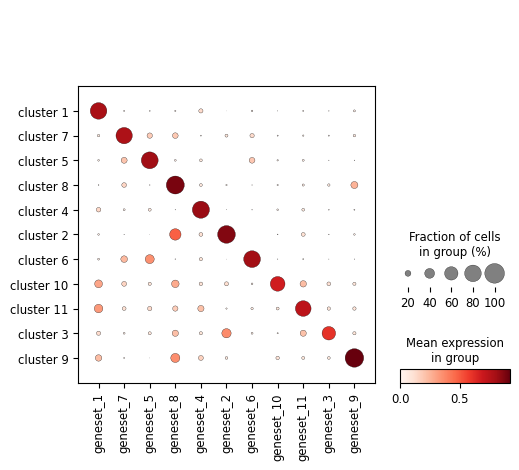

In [16]:
import matplotlib.pyplot as plt

idx_1 = scdata[:,'Pex5l'].X.toarray() == 0 
idx_2 = scdata[:,'Synpr'].X.toarray() > 0
idx_3 = scdata[:,'Otof'].X.toarray() > 0 
idx_4 = scdata[:,'Csmd1'].X.toarray() == 0
set_1 = idx_1 & (idx_2 | idx_3) & idx_4

idx_1 = scdata[:,'Csmd1'].X.toarray() > 0 
idx_2 = scdata[:,'Sox5'].X.toarray() == 0
idx_3 = scdata[:,'Synpr'].X.toarray() > 0
set_2  = idx_1 & idx_2 & idx_3

set_3 = scdata[:,'Mag'].X.toarray() > 0


idx_1  = scdata[:,'Trhde'].X.toarray() > 0
idx_2 = scdata[:,'Epha3'].X.toarray() == 0 
idx_3 = scdata[:,'Satb2'].X.toarray() == 0
set_4 = idx_1 & idx_2 & idx_3

idx_1 = scdata[:,'Pex5l'].X.toarray() > 5
idx_2 = scdata[:,'Erc2'].X.toarray() == 0
set_5 = idx_1 & idx_2

idx_1 = scdata[:,'Kctd16'].X.toarray() == 0
idx_2 = scdata[:,'Grin2b'].X.toarray() == 0
set_6 = idx_1 & idx_2

idx_1 = scdata[:,'Satb2'].X.toarray() > 0
idx_2 = scdata[:,'Bcl11b'].X.toarray() == 0
set_7 = idx_1 & idx_2

idx_1 = scdata[:,'Nrg3'].X.toarray() > 6
idx_2 = scdata[:,'Kcnh7'].X.toarray() > 2
idx_3 = scdata[:,'Nav3'].X.toarray() > 4
set_8 = idx_1  & idx_2 & idx_3

idx_1 = scdata[:,'Nrg3'].X.toarray() > 6
idx_2 = scdata[:,'Nectin3'].X.toarray() > 2
set_9 = idx_1  & idx_2 

set_10 = scdata[:,'Dock8'].X.toarray() > 0
set_11 = scdata[:,'Slc1a3'].X.toarray() > 0 


data = [set_1, set_2, set_3, set_4, set_5, set_6, set_7, set_8, set_9, set_10, set_11]
data = np.array(data, dtype = np.int16).reshape(11,-1).T

import anndata as ad 
sc_dis = ad.AnnData(data, obs = scdata.obs,)
sc_dis.obsm['X_umap'] = scdata.obsm['X_umap'].copy()
sc_dis.var.index = [f'geneset_{i}' for i in range(1,12)]
ax = sc.pl.dotplot(sc_dis, var_names = [f'geneset_{i}' for i in [1,7,5,8,4,2,6,10,11,3,9]], groupby = 'cluster', 
                   categories_order=[f'cluster {i}' for i in [1,7,5,8,4,2,6,10,11,3,9]], show = False)
plt.savefig('dotplot.pdf', bbox_inches = 'tight')

In [146]:

data = [set_1, set_2, set_3, set_4, set_5, set_6, set_7, set_8, set_9, set_10, set_11]
data = np.array(data, dtype = np.int16).reshape(11,-1)
data.shape

(11, 21861)